# Lesson 8 // Neural networks with keras

---

The last decade or so has seen an explosion in interest in neural networks, spurred on by huge successes that various neural network architectures have enjoyed across a number of classification tasks. This notebook shows how to use the Keras neural network library from within R to fit various kinds of neural networks. Keras is a high level library for specifying and training neural networks. It provides a relatively user-friendly way to interact with 3 powerful Python neural network libraries (`Theano`, `TensorFlow`, and `CNTK`) that provide efficient (low-level) tools for working with neural networks. 

The goal of this notebook is to get you up and running with Keras on a couple of "normal" prediction problems. In later notebooks we'll look at some extensions like tricks to boost performance and specific architectures - convolutional neural networks - that have are particularly useful for certain kinds of prediction tasks.

This notebook is meant to be read after going through three spreadsheet-based explanations of three core concepts in neural networks.

1. **Layers**: Neural networks are alternating sequences of linear algebra (matrix multiplication) and non-linear transformations. Each pair of matrix multiplication and non-linear transformation of the result constitutes a layer of the network.
2. **Backpropagation**: a way to train the weight parameters of a neural network, involving passing inputs "forward" through the network to get predictions and hence errors, and then passing these errors "backwards" through the network to adjust the parameters. This happens multiple times until some stopping criterion is met.
3. **Stochastic gradient descent** (or other optimization algorithms): This specifies precisely how errors should be used to update the weights during the backwards pass of the backpropagation algorithm. 

These are contained as worksheets in the accompanying Excel file *"neural-networks-on-a-spreadsheet.xlsx"*.

#### Sources and acknowledgements

There are a lot of excellent sources of neural network information on the web. Some sources that I have used for this notebook are:

* Keras interface to RStudio: https://keras.rstudio.com/ (the MNIST example borrows heavily from here).
* Keras documentation: https://keras.io/
* The [fast.ai](http://www.fast.ai/) neural network course is really excellent and I have pretty shamelessly used Jeremy Howard's spreadsheet examples of the [matrix multiplication step](https://www.youtube.com/watch?v=e3aM6XTekJc&feature=youtu.be&t=3810) and [SGD and related optimizers](https://www.youtube.com/watch?v=V2h3IOBDvrA&feature=youtu.be&t=688)
* Backpropagation is nicely explained [here](https://mattmazur.com/2015/03/17/a-step-by-step-backpropagation-example/)

---

## Installing Keras

See the instructions [here](https://keras.rstudio.com/). You need to (within R/RStudio):

1. install the keras R package from CRAN as follows:
```
install.packages("keras")
```
2. Install both the core Keras library as well as the TensorFlow backend:
```
library(keras)
install_keras()
```

This will provide you with default CPU-based installations of Keras and TensorFlow. If you want a more customized installation, e.g. if you want to take advantage of NVIDIA GPUs, see the documentation for `install_keras()`. 


## Revisiting the Trump tweet classifier

In this section we revisit an example we looked in the notebook on bag-of-words models: trying to use bag-of-words features to predict whether one of Donald Trump's tweets was made before or after he became president. In that notebook we built a classifier using the CART (classification and regression tree) algorithm. Here we'll do the same using a few varieties of feed-forward neural network. 

First we load the packages and data we need. I've created a new .RData file containing the same training and test tweets as we used to build the classification tree. These are saved as the data frames `training_tweets` and `test_tweets` respectively. I've included only the tf-idf features and the outcome variable `is_prez` in each data frame.

In [1]:
library(keras)
library(tidyverse)

load("data/trump_tfidf.RData")

Loading tidyverse: ggplot2
Loading tidyverse: tibble
Loading tidyverse: tidyr
Loading tidyverse: readr
Loading tidyverse: purrr
Loading tidyverse: dplyr
Conflicts with tidy packages ---------------------------------------------------
filter(): dplyr, stats
lag():    dplyr, stats


In [2]:
use_virtualenv("r-tensorflow")

### Data preparation

We first need to split our data along two "dimensions": 

* We need to divide our data into a training data set and a test data set. This is already done but usually you would need to do this here.
* We need to separate the predictor variables/features (the **X** matrix) from the outcome variable (the **y** vector)

Here we first split the training data frame into features `x_train` and outcome `y_train`, converting both to a matrix. The `x_train` matrix has 201 columns (one for each word feature), while `y_train` is a single column vector. The `is_prez` variable is a logical variable so we need to transform that into numerical variable for later use with `to_categorical`. There is probably a neater way to do this than I do below.

In [3]:
x_train <- as.matrix(training_tweets %>% select(-is_prez), ncol = 201)
y_train <- as.matrix(1 * (training_tweets %>% select(is_prez)), ncol = 1)

In [4]:
x_test <- as.matrix(test_tweets %>% select(-is_prez), ncol = 201)
y_test <- as.matrix(1 * (test_tweets %>% select(is_prez)), ncol = 1)

### Basic feed-forward neural network

We'll start by creating a simple 3-layer, fully connected network. This network has a single hidden layer, in addition to the input and output layers. We'll then add some more complexity by adding layers. In each case we use a very similar model building and testing strategy:

* Create the model
* Define and compile the model
* Train/fit the model
* Evaluate the model

We go through each of these steps on more detail below.

#### Create the model

A Keras "model" is a way to organize layers. We use the "sequential" model, in which each layer of the model follows sequentially from the previous one, so that we build up a linear stack of layers using the pipe (%>%) operator. The other kind of Keras model is a "functional" model, which is useful for more complex cases and which we'll cover in another notebook. 

We begin by creating an empty sequential model:

In [5]:
model <- keras_model_sequential()

#### Define the model

We define a model by sequentially adding layers. Each layer consists of 

* a way of connecting up the neurons from the previous layer with neurons in this layer,
* an activation function, which takes as input the pre-activation (coming from the input neurons or the previous layer of neurons) and calculates an output. This can be interpreted as the rate of how much a neuron is firing.  The simplest form of such a function is that of a binary function, where the neuron is either firing or not.

In Keras, you can specify both of these parts together, or you can separate them out. Thus below

```
layer_dense(units = 32, input_shape = c(201)) %>% layer_activation('relu')
``` 

is entirely equivalent to 

```
layer_dense(units = 32, input_shape = c(201), activation = 'relu')
``` 

Below we define a model with a single hidden layer i.e. a three-layer feed-forward neural network. Note that we don't need to reassign the piped result back to `model` (i.e. `model <- model %>% ...`). This happens automatically. Take care with this - if you want to start with a fresh model you need to do this with a new call to `keras_model_sequential()`!

The first layer we add specifies both the shape of the input data and the number of neurons we want in the first hidden layer (32). The shape of the input data is specified in the `input_shape` argument i.e. a length 201 numeric vector representing the tf-idf values of the tweet. A dense layer (`layer_dense`) specifies a fully connected layer, in which each of these 201 input neurons will be connected up with each of the 32 neurons in the hidden layer. This gives 6432 parameters to be estimated - with bias terms for each hidden neuron, this makes 6464 parameters. 

We use a rectified linear unit or "relu" activation function to non-linearly transform the pre-activation values (i.e. the weighted sum of inputs to each neuron in this layer). The role of the activation function is to add non-linearity to the neural network and hence provide the flexibility that give neural networks their predictive power (otherwise we'd just have a series of matrix multiplications that we could reduce to a single one). You can read more about activations functions [here](https://www.quora.com/What-is-the-role-of-the-activation-function-in-a-neural-network-How-does-this-function-in-a-human-neural-network-system/answer/Sebastian-Raschka-1). The plot below shows a few popular activation functions:

<img src="figures/lesson8/activations.png" />

Together, the call to `layer_dense()` and `layer_activation()` define the hidden layer.

The only other layer outputs a length 1 numeric vector (probabilities for the "post-presidential" class) using a sigmoid activation function. Each of the 32 neurons in the hidden layer are connected to the output neuron, giving another 33 parameters to be estimated (including bias). We end by using the `summary()` function to print the details of the model.

In [6]:
model %>% 
  layer_dense(units = 32,                  # number of neurons in the hidden layer
              input_shape = c(201)) %>%    # dimension of input array
  layer_activation('relu') %>%             # use a rectified linear unit as an activation function in the hidden layer
  layer_dense(units = 1) %>%               # adds an output layer to the network
  layer_activation('sigmoid')              # use sigmoid activation function in the output layer

In [7]:
summary(model)

________________________________________________________________________________
Layer (type)                        Output Shape                    Param #     
dense_1 (Dense)                     (None, 32)                      6464        
________________________________________________________________________________
activation_1 (Activation)           (None, 32)                      0           
________________________________________________________________________________
dense_2 (Dense)                     (None, 1)                       33          
________________________________________________________________________________
activation_2 (Activation)           (None, 1)                       0           
Total params: 6,497
Trainable params: 6,497
Non-trainable params: 0
________________________________________________________________________________


#### Compile the model 

Keras is built on top of Theano and TensorFlow, both packages that take the symbolic *computational graph* of the model and compile it in an efficient implementation that can then be used to train and evaluate the model. 

When compiling a model, Keras asks you to specify your **loss function** and your **optimizer**.  Here we use logarithmic loss as the loss function, which for two-class problems is called *binary crossentopy* by Keras (*categorical crossentropy* for multi-class classification problems). Cross-entropy is a measure of how different two probability distributions are. In this case we have two distributions (for each observation), a predicted distribution and a target distribution. 

* Our predictions are a probability distribution across the two classes (e.g. "we're 80% confident this tweet is a pre-president tweet and 20% sure it's a post-president tweet").
* The target is a probability distribution with 100% for the correct category, and 0 for the other category. 

For example, say we have a tweet that we know to be pre-presidential, and that our model allocates a probability of 0.8 to that class. Then:
* observed "probability" for class 1 = 100%, for class 2 = 0%
* predicted probability for class 1 = 80%, predicted probability for class 2 = 20%
* log loss $= - (1\times\log(0.8) + 0\times\log(0.2))$

Total log loss would be calculated by summing over all observations in the training set.

The optimizer helps determine how quickly the model learns, how resistent it is to getting "stuck" or "blowing up".  The chosen optimization algorithm will help to find optimized values for the weights which minimizes the error (or maximizes the accuracy). Popular choices for the optimizer include stochastic gradient descent, Adam and RMSprop.

In [8]:
model %>% compile(
  optimizer = 'rmsprop',
  loss = 'binary_crossentropy',
  metrics = c('accuracy')
)

We could have done the define and compile steps together, using the pipe, if we wanted to:

```
model %>% 
  layer_dense(units = 32, activation = 'relu', input_shape = c(201)) %>% 
  layer_dense(units = 2, activation = 'softmax') %>% 
  compile(
    optimizer = 'SGD',
    loss = 'binary_crossentropy',
    metrics = c('accuracy')
  )
```

#### Train the model

Next we train the model on our training data. We use **batch training** with a batch size of 32.  This approach sends groups of 32 training tweets through the network at a time.  Adjustments to the weights and biases (deltas) from each training tweet are accumulated and updated once after each batch. Watch the loss, which is the objective function which we are minimising, and the estimated accuracy of the model.

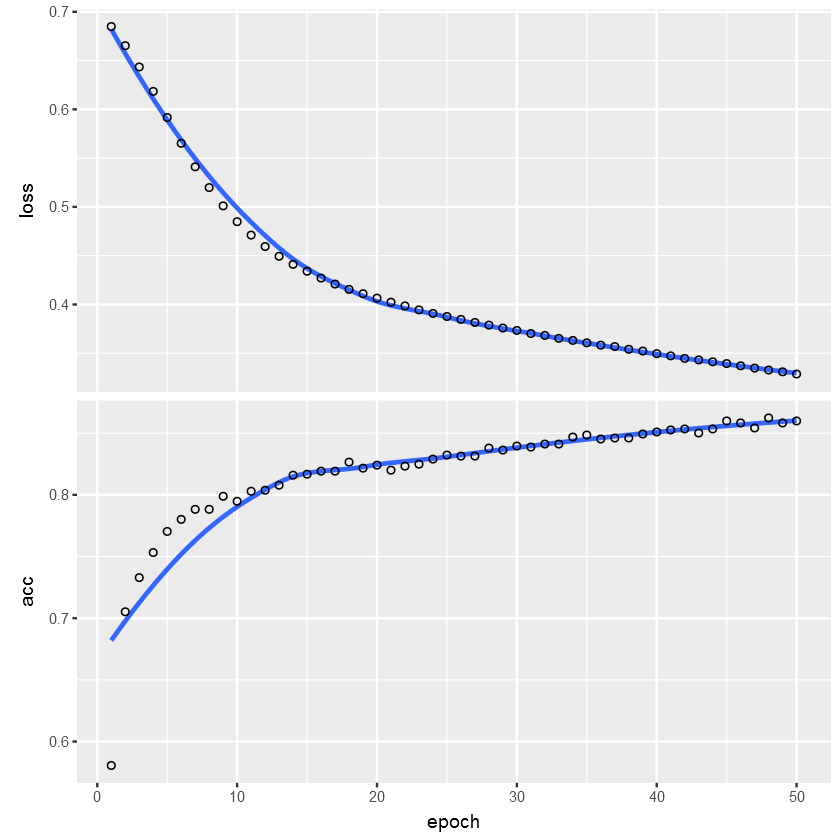

In [9]:
model %>% fit(x_train, y_train, epochs = 50, batch_size = 32) %>% plot()

Note if we want to run for (say) 5 *further* epochs, we just make another call to `fit()`. 

In [10]:
model %>% fit(x_train, y_train, epochs = 5, batch_size = 32)

#### Evaluate the model 

Once the model is trained, we can evaluate its performance on the test data.

In [11]:
model %>% evaluate(x_test, y_test, batch_size=32, verbose = 1)

$loss
[1] 0.6440015

$acc
[1] 0.717496

#### Generate predictions on new data (e.g. test data)

This is done in a straightforward way by passing new data to `predict_classes()`

In [12]:
model %>% predict_classes(x_test) %>% head()

0
1
1
1
1
1


### Adding more layers = Deep learning

Adding additional layers is straightforward in Keras. In this secton we build a model with two (rather than one) hidden layers. This model has the same number of hidden nodes as the previous model, half in each of the hidden layers. We use the same steps as before, so just give the headings.

#### Create the model

In [13]:
model2 <- keras_model_sequential()

#### Define and compile the model

In [14]:
model2 %>% 
  layer_dense(units = 16, activation = 'relu', input_shape = c(201)) %>% 
  layer_dense(units = 16, activation = 'relu') %>% 
  layer_dense(units = 1, activation = 'sigmoid') %>% 
  compile(
    loss = 'binary_crossentropy',
    optimizer = 'rmsprop',
    metrics = c('accuracy')
  )

In [15]:
summary(model2)

________________________________________________________________________________
Layer (type)                        Output Shape                    Param #     
dense_3 (Dense)                     (None, 16)                      3232        
________________________________________________________________________________
dense_4 (Dense)                     (None, 16)                      272         
________________________________________________________________________________
dense_5 (Dense)                     (None, 1)                       17          
Total params: 3,521
Trainable params: 3,521
Non-trainable params: 0
________________________________________________________________________________


#### Train the model

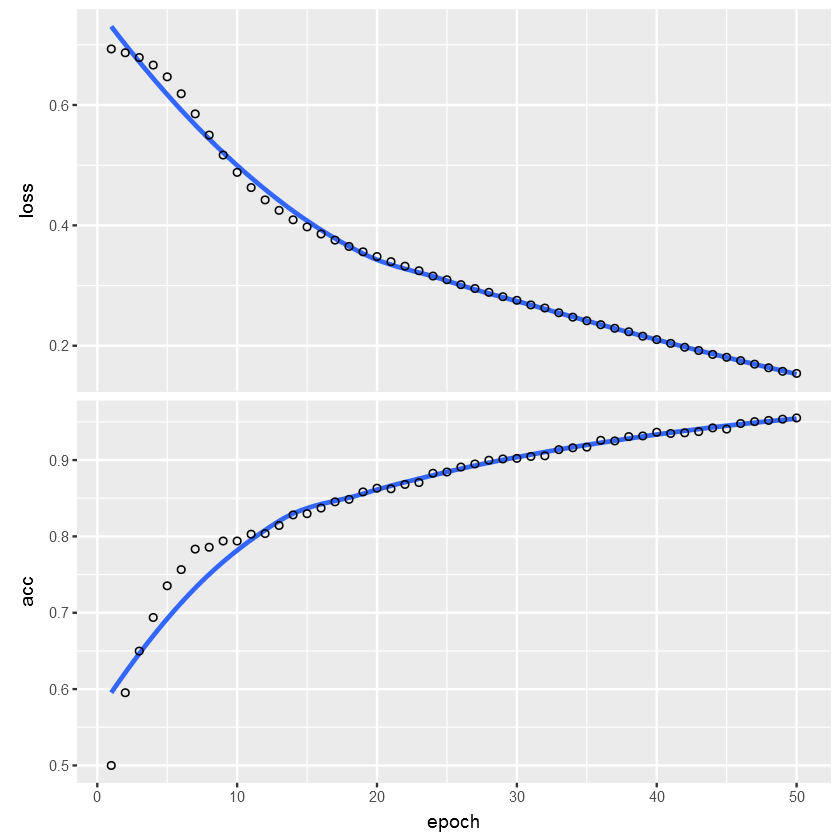

In [16]:
model2 %>% fit(x_train, y_train, epochs = 50, batch_size = 32) %>% plot()

#### Evaluate the model 

In [17]:
model2 %>% evaluate(x_test, y_test, batch_size=32, verbose = 1)

$loss
[1] 0.833858

$acc
[1] 0.7255217

### Adding dropout

Dropout is a technique for avoiding overfitting in neural networks. The idea is that randomly selected neurons (together with their connections) are ignored during training. In each layer, we specify the proportion of neurons to exclude - in the example below we use a dropout rate of 20%. You can read more about dropout (although that is pretty much all there is to it!) in the original paper [here](http://www.jmlr.org/papers/volume15/srivastava14a/srivastava14a.pdf).

#### Create the model

In [18]:
model3 <- keras_model_sequential()

#### Define and compile the model

In [19]:
model3 %>% 
  layer_dense(units = 16, activation = 'relu', input_shape = c(201)) %>%
  layer_dropout(rate = 0.2) %>% 
  layer_dense(units = 16, activation = 'relu') %>% 
  layer_dropout(rate = 0.2) %>% 
  layer_dense(units = 1, activation = 'sigmoid') %>% 
  compile(
    loss = 'binary_crossentropy',
    optimizer = 'rmsprop',
    metrics = c('accuracy')
  )

#### Train the model

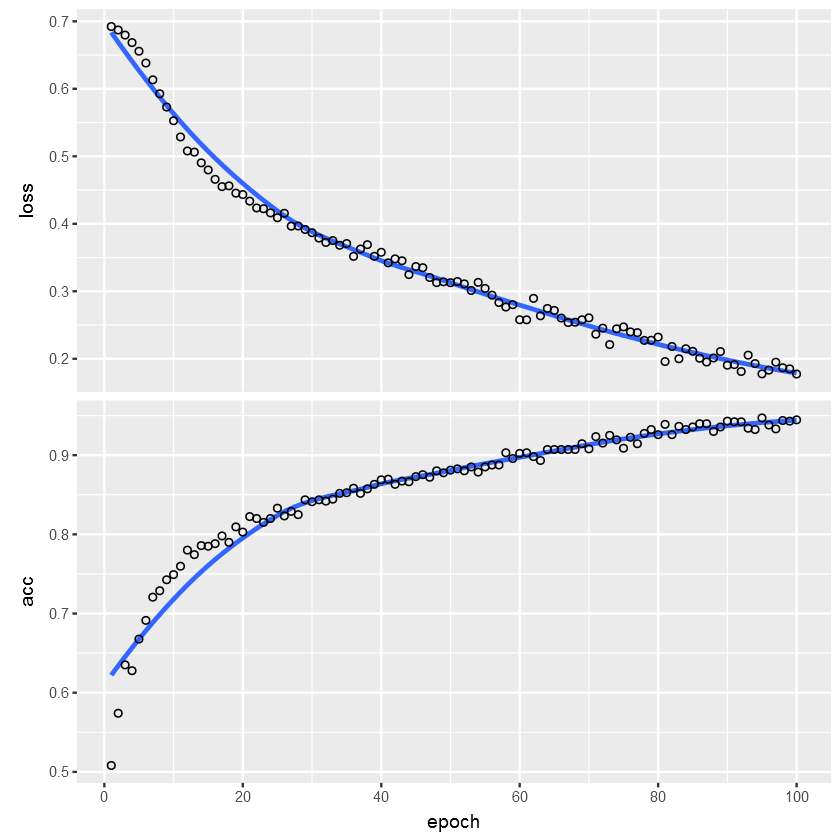

In [20]:
model3 %>% fit(x_train, y_train, epochs = 100, batch_size = 32) %>% plot()

#### Evaluate the model 

In [21]:
model3 %>% evaluate(x_test, y_test, batch_size=32, verbose = 1)

$loss
[1] 0.9272895

$acc
[1] 0.7223114

## Another tutorial: the MNIST dataset

No introduction to neural networks is complete without the MNIST dataset! :) The MNIST dataset is a handwritten digit recognition problem, in which handwritten digits (represented by 28x28 grayscale images) must be classified into one of the 10 digits (0,1,...,9). I included it here to give a quick introduction to multi-class classification. The dataset is included with Keras and can be accessed using the `dataset_mnist()` function. 

We first load the **imager** package, which has many useful tools for image processing (we just use it to plot a few sample images), and then the data. 

In [22]:
library(imager)

Loading required package: plyr
------------------------------------------------------------------------------
You have loaded plyr after dplyr - this is likely to cause problems.
If you need functions from both plyr and dplyr, please load plyr first, then dplyr:
library(plyr); library(dplyr)
------------------------------------------------------------------------------

Attaching package: 'plyr'

The following objects are masked from 'package:dplyr':

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize

The following object is masked from 'package:purrr':

    compact

Loading required package: magrittr

Attaching package: 'magrittr'

The following object is masked from 'package:purrr':

    set_names

The following object is masked from 'package:tidyr':

    extract


Attaching package: 'imager'

The following object is masked from 'package:magrittr':

    add

The following object is masked from 'package:plyr':

    liply

The following object is masked f

In [23]:
mnist <- dataset_mnist()

### Data preparation

As before, we split the data into test and training data, and identify features and outcome variables. The `x_train` and `x_test` data are each 3-d arrays (images,width,height) of grayscale values. The `y_train` and `y_test` data consist of integers from 0-9.  

In [24]:
x_train <- mnist$train$x
y_train <- mnist$train$y
x_test <- mnist$test$x
y_test <- mnist$test$y

Here we just plot a few of the images.

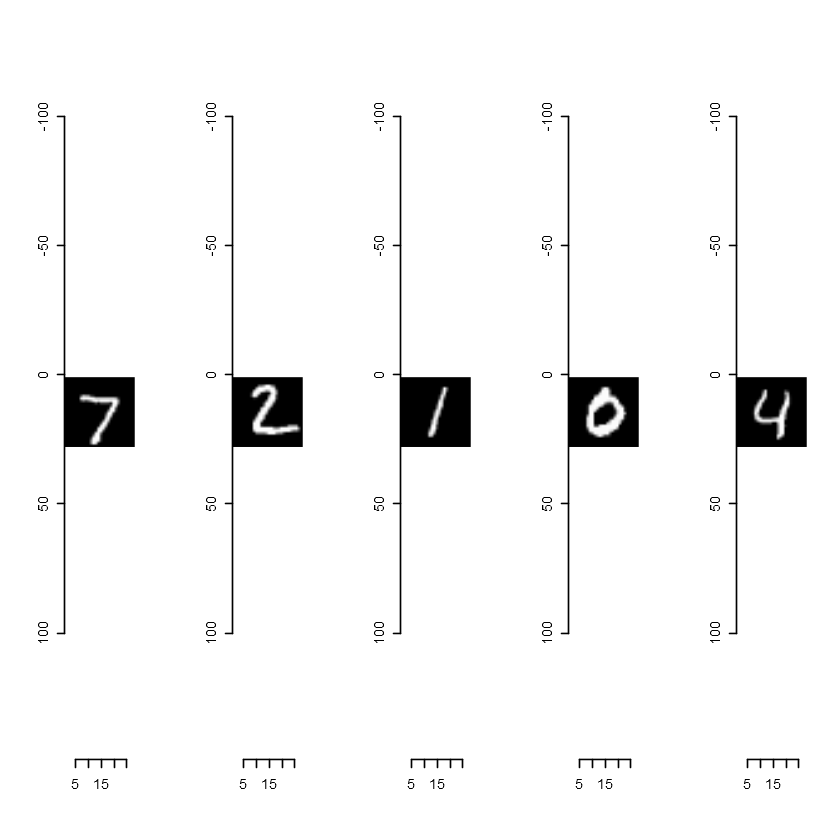

In [25]:
par(mfrow = c(1,5))
for(i in 1:5){plot(as.cimg(t(x_test[i,,])))}

In our model we are going to treat each pixel independently, by "unravelling" the 28x28 matrix into a vector of length 784. We also convert the grayscale values from integers ranging between 0 to 255 into floating point values ranging between 0 and 1.

In [26]:
# reshape
dim(x_train) <- c(nrow(x_train), 784)
dim(x_test) <- c(nrow(x_test), 784)
# rescale
x_train <- x_train / 255
x_test <- x_test / 255

The output variable is an integer taking on integers 0 through 9, so this is a multi-class classification problem. It is good practice to use **one-hot encoding** for the class values. This transforms the vector of class integers into a binary matrix:

```
0 -> [1, 0, 0, 0, 0, 0, 0, 0, 0]
1 -> [0, 1, 0, 0, 0, 0, 0, 0, 0]
2 -> [0, 0, 1, 0, 0, 0, 0, 0, 0]
etc.
```
One-hot encoding is implemented with the Keras `to_categorical()` function:

In [27]:
y_train <- to_categorical(y_train, 10)
y_test <- to_categorical(y_test, 10)

We can now carry out the same model buildings steps as before.

#### Create the model

In [28]:
model <- keras_model_sequential() 

#### Define the model

Here we fit a sequential model with two hidden layers and dropout. The first hidden layer consists of 128 neurons, the second 64. Both hidden layers use relu activations. 

The final output layer now has 10 neurons, one for each of the classes/digits. We use a softmax activation in the output layer. The softmax activation has the property that it forces the outputs of a neural network to sum to 1, so that they can represent valid probabilities for each class. The transformation is given by:

$$g(\textbf{a}) = \text{softmax}(\textbf{a}) = \left[ \frac{\exp{(a_1)}}{\Sigma_c \exp{(a_c)}} \ldots \frac{\exp{(a_C)}}{\Sigma_c \exp{(a_c)}} \right]^T $$

The transformed values - the activations - sum to 1 across classes and are stricly positive. The predicted class is whichever class receives the highest predicted probability.

In [29]:
model %>% 
  layer_dense(units = 128, activation = 'relu', input_shape = c(784)) %>% 
  layer_dropout(rate = 0.4) %>% 
  layer_dense(units = 64, activation = 'relu') %>%
  layer_dropout(rate = 0.3) %>%
  layer_dense(units = 10, activation = 'softmax')

In [30]:
summary(model)

________________________________________________________________________________
Layer (type)                        Output Shape                    Param #     
dense_9 (Dense)                     (None, 128)                     100480      
________________________________________________________________________________
dropout_3 (Dropout)                 (None, 128)                     0           
________________________________________________________________________________
dense_10 (Dense)                    (None, 64)                      8256        
________________________________________________________________________________
dropout_4 (Dropout)                 (None, 64)                      0           
________________________________________________________________________________
dense_11 (Dense)                    (None, 10)                      650         
Total params: 109,386
Trainable params: 109,386
Non-trainable params: 0
_____________________________________

#### Compile the model

Here our predictions are probability distributions across the ten different digits (e.g. "we're 80% confident this image is a 3, 10% sure it's an 8, 5% it's a 2, etc."), and the target is a probability distribution with 100% for the correct category, and 0 for everything else. We use categorical cross-entropy, an extension of the binary cross-entropy we looked at in the previous example to multi-class classification problems.

In [31]:
model %>% compile(
  loss = 'categorical_crossentropy',
  optimizer = 'rmsprop',
  metrics = c('accuracy')
)

#### Train the model

Use the fit() function to train the model for 30 epochs using batches of 128 images. Here we specify a `validation_split`, which further splits the "training" data into true "training" data and validation data that can be used to do finetuning, in the sense of choosing hyperparameters of the neural network, like the dropout rate. This should *not* be done on the test data, which should always be kept as a totally independent and unseen dataset.

In [32]:
history <- model %>% fit(
  x_train, y_train, 
  epochs = 3, batch_size = 32, 
  validation_split = 0.2
)

The history object returned by fit() includes loss and accuracy metrics which we can plot:

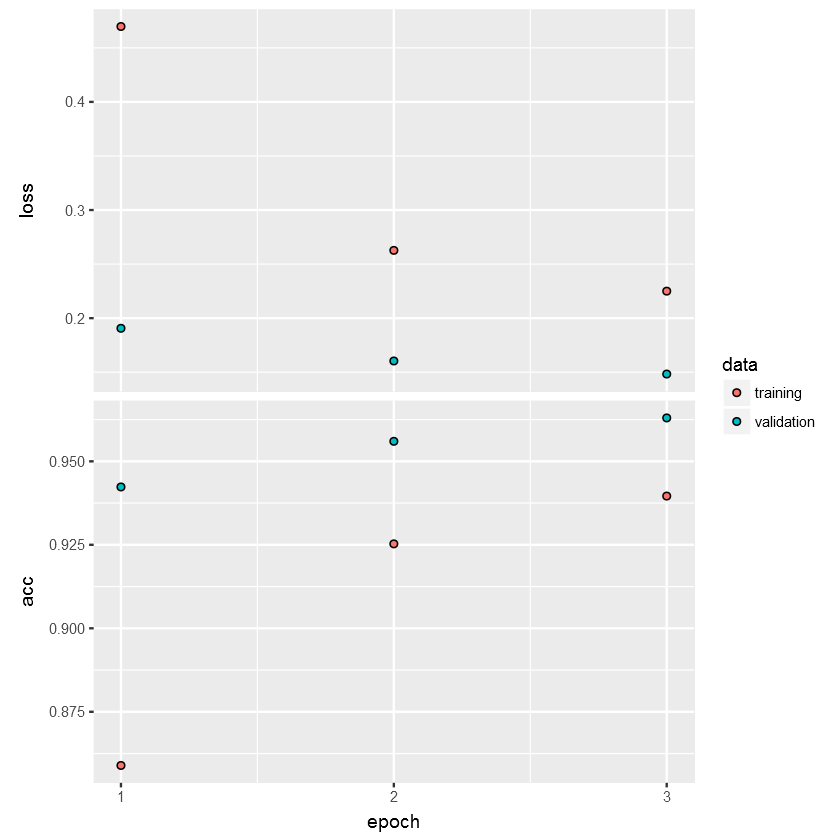

In [33]:
plot(history)

#### Evaluate the model

In [34]:
model %>% evaluate(x_test, y_test)

$loss
[1] 0.1440415

$acc
[1] 0.9631

Let's have a look at some of the images the model incorrectly predicted.

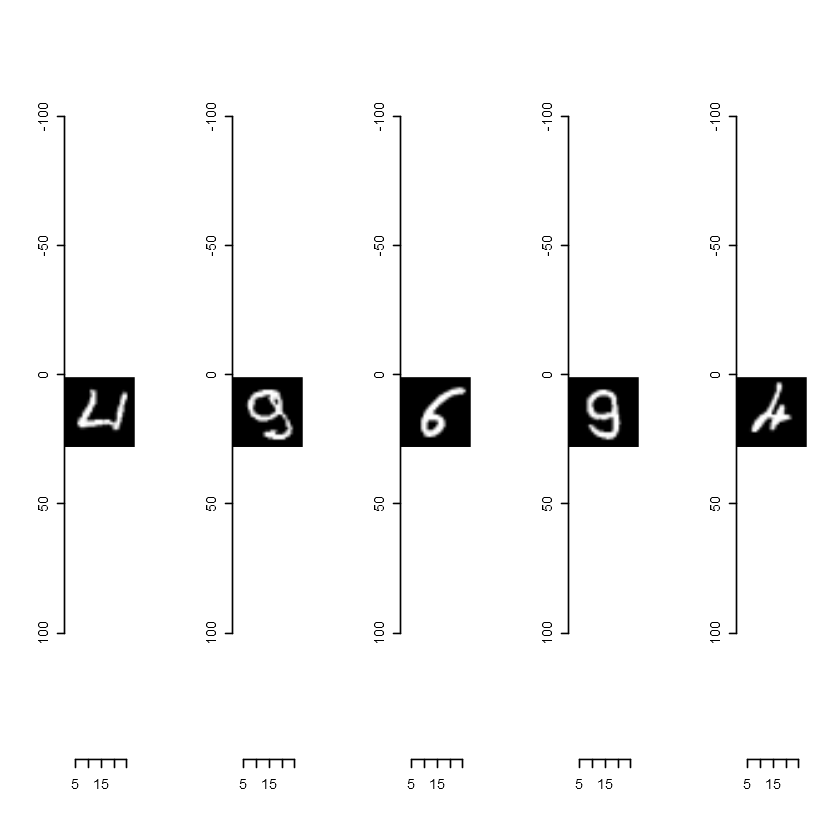

In [35]:
preds <- model %>% predict_classes(x_test)              # get predicted classes for test data
wrong_preds <- tibble(id = 1:nrow(y_test),              # make tibble with obs, pred, and id
                      obs = mnist$test$y, 
                      preds = preds) %>%
filter(obs != preds)                                    # identify incorrect classifications

par(mfrow = c(1,5))
for(i in 1:5){      
    wrong_x <- mnist$test$x[wrong_preds$id[i],,]        # extract pixel values for incorrectly class. image
    plot(as.cimg(t(wrong_x)))                           # plot image
}

## Exercises

No real exercises this week, just get Keras installed and up and running. There are a number of nice examples on the RStudio Keras site, [here](https://keras.rstudio.com/articles/examples/index.html).